# Задание 3. Распознавание образов, описываемых гауссовскими случайными векторами с разными матрицами ковариаций

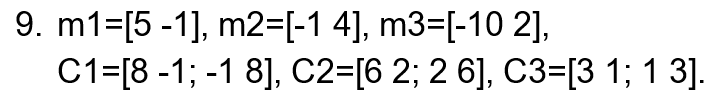

### 1. Задание исходных данных

In [39]:
import numpy as np
np.set_printoptions(precision= 5, suppress=False)

In [40]:
n = 2 #размерность признакового пространства
M = 3 #число классов
K = 10000 #количество статистических испытаний
dm = 2 #расстояние между матожиданиями вдоль координатных осей
pw = np.array([0.33, 0.34, 0.33]) #априорные вероятности классов
m = dm*np.matrix([[5, -1, -10], [-1, 4, 2]]) #матожидания (записаны как у Сироты)
C = np.array([[[8,6,3],[-1,2,1]], [[-1,2,1],[8,6,3]]]) #матрица ковариаций
C_ = np.zeros([n, n, M]) #матрица, обратная к матрице ковариаций
for i in range(M):
    C_[:,:, i]=np.linalg.inv(C[:,:,i])
D = np.array([[3, 1, 1], [1, 1, 5]])  #дисперсия (записано как у Сироты)

### 2. Расчет разделяющих функций и вероятностей ошибок разпознавания

In [41]:
P_err =  np.zeros((M, M))
P_err_chernov =  np.zeros((M, M)) #граница Чернова
l0 = np.zeros((M,M))

In [42]:
from scipy.stats import norm
for i in range(M):
    for j in range(i+1, M):
        dm_ij=m[:,i]-m[:,j]
        l0[i,j]=np.log(pw[j]/pw[i])
        det_i=np.linalg.det(C[:,:,i]) 
        det_j=np.linalg.det(C[:,:,j])
        trace_ij=np.trace(C_[:,:,j]*C[:,:,i]-np.eye(n))
        trace_ji=np.trace(np.eye(n)-C_[:,:,i]*C[:,:,j])
        mg1=0.5*(trace_ij+np.transpose(dm_ij)*C_[:,:,j]*dm_ij-np.log(det_i/det_j))
        Dg1=0.5*trace_ij**2+np.transpose(dm_ij)*C_[:,:,j]*C[:,:,i]*C_[:,:,j]*dm_ij 
        mg2=0.5*(trace_ji-np.transpose(dm_ij)*C_[:,:,i]*dm_ij+np.log(det_j/det_i))
        Dg2=0.5*trace_ji**2+np.transpose(dm_ij)*C_[:,:,i]*C[:,:,j]*C_[:,:,i]*dm_ij
        sD1=np.sqrt(Dg1)
        sD2=np.sqrt(Dg2)
        P_err[i,j]=norm.cdf(l0[i,j],mg1,sD1)
        P_err[j,i]=1-norm.cdf(l0[i,j],mg2,sD2)
        mu=0.125*np.transpose(dm_ij)*np.linalg.inv(C[:,:,i]+C[:,:,j])*0.5*dm_ij+\
            0.5*np.log((det_i+det_j)/(2*np.sqrt(det_i*det_j))) #расстояние Бхатачария      
        P_err_chernov[i,j]=np.sqrt(pw[j]/pw[i])*np.exp(-mu)
        P_err_chernov[j,i]=np.sqrt(pw[i]/pw[j])*np.exp(-mu)
    P_err_chernov[i,i]=1-np.sum(P_err_chernov[i,:])
    P_err[i,i]=1-np.sum(P_err[i,:])

### 3.Тестирование алгоритма методом статистических испытаний

In [43]:
#Функция для вычисления экспериментальной матрицы ошибок
def experiment_error(K):
    x=np.ones((n, 1))
    u=np.zeros((M, 1))
    P_err_experiment=np.zeros((M, M)) #экспериментальная матрица ошибок
    for k in range(K): #цикл по испытаниям
        for i in range(M): #цикл по классам
            x+=m[:,i] #генерация образа i-го класса
            for j in range(M): #вычисление значения разделяющих функций
                u[j]=-0.5*np.transpose(x-m[:,j])*C_[:,:,j]*(x-m[:,j])-\
                0.5*np.linalg.det(C[:,:,j])+np.log(pw[j])
            u_max=u.max() #определение максимума
            u_max_num=np.where(u==u_max)[0]
            P_err_experiment[i, u_max_num]+=1
    P_err_experiment/=K
    return P_err_experiment

In [44]:
errors=experiment_error(1000)
print('Экспериментальная матрица ошибок:\n{0}\n'.format(errors))

Экспериментальная матрица ошибок:
[[ 0.997  0.002  0.001]
 [ 0.997  0.003  0.   ]
 [ 0.998  0.     0.002]]



In [45]:
np.set_printoptions(suppress=True)
print('Теоретическая матрица вероятностей ошибок:\n {0}'.format(P_err))
print('Матрица вероятностей ошибок на основе границы Чернова:\n {0}'.format(P_err_chernov))

Теоретическая матрица вероятностей ошибок:
 [[ 0.99544  0.00456  0.     ]
 [ 0.00005  0.99985  0.0001 ]
 [ 0.       0.       1.     ]]
Матрица вероятностей ошибок на основе границы Чернова:
 [[ 0.69036  0.30574  0.0039 ]
 [ 0.29675  0.61323  0.09002]
 [ 0.0039   0.09275  0.90336]]


### 4.Визуализация

In [46]:
 #суммарные ошибки для теоритеческой матрицы ошибок:
sumErr_1=pw[0]*P_err[0,1]+pw[1]*P_err[1,0]
#суммарные ошибки для границы Чернова:
sumErr_2=(np.sqrt(pw[0]*pw[1])*np.exp(-mu))[0,0]
#суммарные ошибки для экспериментальной матрицы вероятностей ошибок:
sumErr_3=pw[0]*errors[0,1]+pw[1]*errors[1,0]
print('Оценки суммарных веротностей ошибок:')
print([sumErr_1, sumErr_2, sumErr_3])

Оценки суммарных веротностей ошибок:
[0.0015200051753155592, 0.030606039549386978, 0.33964]


In [47]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [48]:
xMin=m[0,:].min()-3*np.sqrt(D[0,:].max())
xMax=m[0,:].max()+3*np.sqrt(D[0,:].max())
yMin=m[1,:].min()-3*np.sqrt(D[1,:].max())
yMax=m[1,:].max()+3*np.sqrt(D[1,:].max())

step=0.1
x, y = np.mgrid[xMin:xMax:step, yMin:yMax:step] #x и y от минимального до максимального

In [49]:
def draw_areas():
    xy = np.dstack((x, y)) #все возможные комбинации x и y
    for i in range(M): #рисуем контур для каждого облака
        rv = multivariate_normal(np.array(m)[:, i], C[:,:,i])
        plt.contour(x, y, rv.pdf(xy))

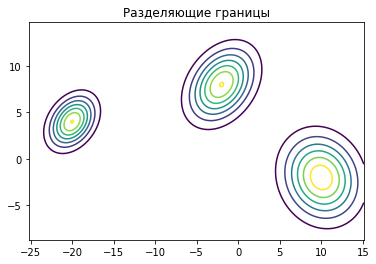

In [50]:
draw_areas()
plt.title('Разделяющие границы')
plt.show()

In [51]:
def generate_points(m, C, n):
    vals = np.zeros((M, 2, n))
    for i in range(0, M):
        rv = multivariate_normal(np.array(m)[:, i], C[:,:,i])
        for j in range(0, n):
            x, y = rv.rvs()
            vals[i, 0:2, j] = rv.rvs()            
    return vals

def draw_points(points, plot):    
    colors = ['r', 'g', 'b']    
    for i in range(0, M):
        plot.scatter(points[i, 0, :], points[i, 1, :], c=colors[i], s=10)

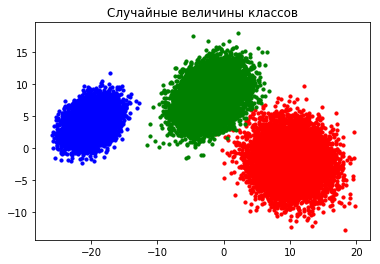

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)
vals = generate_points(m, C, K)
draw_points(vals, ax)
plt.title('Случайные величины классов')
plt.show()

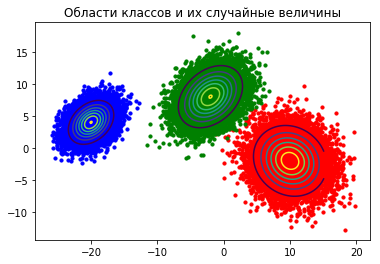

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)
draw_points(vals, ax)
draw_areas()
plt.title('Области классов и их случайные величины')
plt.show()

In [54]:
def g(x, i):    
    x_ = x.transpose()
    mi = m[:,i]
    mi_ = mi.transpose()
    val = -0.5*np.log(np.linalg.det(C[:,:,i]))
    val += -0.5*x_.dot(C_[:,:,i]).dot(x)
    val += x_.dot(C_[:,:,i]).dot(mi)
    val += -0.5*mi_.dot(C_[:,:,i]).dot(mi)
    val += np.log(1 / 2)    
    return val

def draw_lines():
    xy = np.vstack([ x.reshape(-1), y.reshape(-1) ])    
    lenX, lenY = x.shape
    for i in range(M):
        for j in range(i+1, M):            
            arr = np.zeros((lenX*lenY))
            for k in range(0, lenX*lenY):            
                x_ = xy[:, [k]]                
                arr[k] = g(x_, i) - g(x_, j)                
            ax.contour(x, y, arr.reshape((lenX, lenY)), 0)

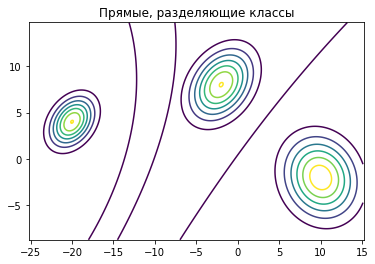

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis((xMin, xMax, yMin, yMax))
draw_lines()
draw_areas()
plt.title('Прямые, разделяющие классы')
plt.show()
plt.clf()